# PROG8245 – Machine Learning Programming
# Project: Mental Health Support Text Messages Dataset Analysis using NLP Techniques


Group 4 : 

         Divyamol Madathilparambil Sunilkumar(8944434)

        Sruthi ajithakumari somashekaran nair (8960908)


* This script performs sentiment classification using the GoEmotions dataset.
* It maps fine-grained emotion labels to three sentiment classes: positive, negative, and neutral.


## 1. Project Overview

Analyze mental health-related text messages and classify them into positive, neutral, or negative sentiments using NLP techniques. The goal is to support emotional well-being detection through automated sentiment classification.


In [40]:
# Import Libraries

import pandas as pd
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset


In [41]:

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # also sometimes needed for WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Dataset : GoEmotions

The GoEmotions dataset, developed by Google Research, is a large-scale collection of over 58,000 Reddit comments annotated with 27 fine-grained emotions. It is highly suitable for our project on sentiment analysis, which requires classifying text into at least three sentiment classes: **positive**, **negative**, and **neutral**. The dataset was adapted by mapping the 27 emotion labels into these three broader sentiment categories. For example, emotions like `joy`, `love`, and `gratitude` were classified as positive, while `anger`, `fear`, and `sadness` were labeled negative. Emotions such as `neutral`, `surprise`, and `realization` were grouped under the neutral category.



In [42]:

# Load GoEmotions dataset
dataset = load_dataset("go_emotions", "raw")
df = pd.DataFrame(dataset['train'])


In [43]:
df.columns


Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [44]:
# Define Sentiment Mapping

positive = {'admiration', 'amusement', 'approval', 'caring', 'desire',
            'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'}

negative = {'anger', 'annoyance', 'disappointment', 'disapproval', 'embarrassment',
            'fear', 'grief', 'nervousness', 'remorse', 'sadness', 'disgust'}

neutral = {'neutral', 'realization', 'curiosity', 'confusion', 'surprise'}


In [45]:
def detect_sentiment(row):
    for emotion in positive:
        if emotion in row and row[emotion] == 1:
            return 'positive'
    for emotion in negative:
        if emotion in row and row[emotion] == 1:
            return 'negative'
    return 'neutral'  # default to neutral if nothing matches


In [46]:
df['sentiment'] = df.apply(detect_sentiment, axis=1)


In [47]:
# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [48]:

# Define cleaning function
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)       # Remove mentions & hashtags
    text = re.sub(r'[^\w\s]', '', text)         # Remove punctuation/emojis
    text = re.sub(r'\d+', '', text)             # Remove numbers
    tokens = text.split()                       # Tokenize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [49]:

# Apply to dataset
df['cleaned_text'] = df['text'].apply(clean_text)


In [50]:

# Drop irrelevant columns (if present)
columns_to_drop = ['example_very_unclear', 'subreddit', 'id', 'created_utc']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')


In [51]:

# Check for missing values
print("Missing values summary:")
print(df.isnull().sum())


Missing values summary:
text              0
author            0
link_id           0
parent_id         0
rater_id          0
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
sentiment         0
cleaned_text      0
dtype: int64


In [52]:

# Preview cleaned data
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,That game hurt.,game hurt
1,>sexuality shouldn’t be a grouping category I...,sexuality shouldnt grouping category make diff...
2,"You do right, if you don't care then fuck 'em!",right dont care fuck em
3,Man I love reddit.,man love reddit
4,"[NAME] was nowhere near them, he was by the Fa...",name nowhere near falcon


In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [54]:

# Use cleaned_text and sentiment from df
X_text = df['cleaned_text']
y = df['sentiment']


In [55]:

# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [56]:

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y_encoded, test_size=0.2, random_state=42)


In [57]:

# ========== 1. Bag-of-Words ==========
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)


In [58]:

# ========== 2. TF-IDF ==========
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)


In [59]:

# ========== 3. Word2Vec Embedding ==========
# Load pretrained Word2Vec
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")


In [60]:

# Function to average word vectors
def vectorize_w2v(texts):
    vectors = []
    for sentence in texts:
        tokens = sentence.split()
        word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(300))
    return np.array(vectors)


In [61]:

X_train_w2v = vectorize_w2v(X_train_text)
X_test_w2v = vectorize_w2v(X_test_text)


In [62]:
def train_and_evaluate(X_train, X_test, y_train, y_test, label_encoder, name="Model"):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model


=== Bag-of-Words + Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.59      0.47      0.53      9772
     neutral       0.57      0.69      0.63     15943
    positive       0.73      0.67      0.70     16530

    accuracy                           0.63     42245
   macro avg       0.63      0.61      0.62     42245
weighted avg       0.64      0.63      0.63     42245



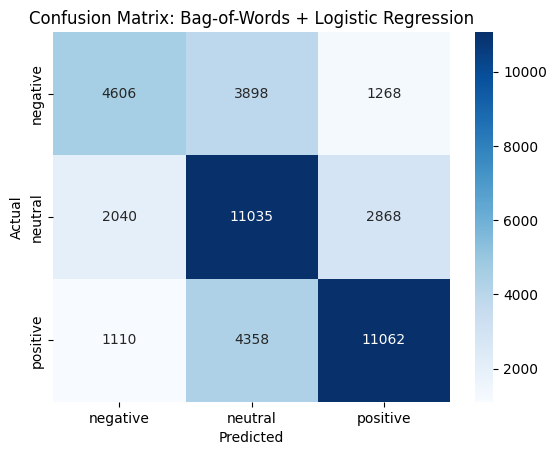

=== TF-IDF + Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.59      0.47      0.53      9772
     neutral       0.58      0.68      0.62     15943
    positive       0.72      0.68      0.70     16530

    accuracy                           0.63     42245
   macro avg       0.63      0.61      0.62     42245
weighted avg       0.64      0.63      0.63     42245



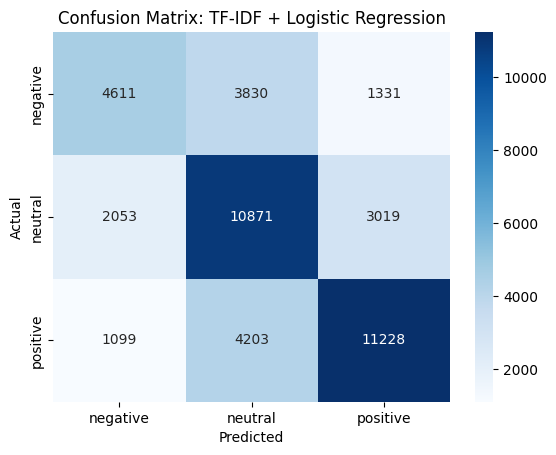

=== Word2Vec + Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.56      0.36      0.43      9772
     neutral       0.53      0.65      0.58     15943
    positive       0.67      0.65      0.66     16530

    accuracy                           0.58     42245
   macro avg       0.58      0.55      0.56     42245
weighted avg       0.59      0.58      0.58     42245



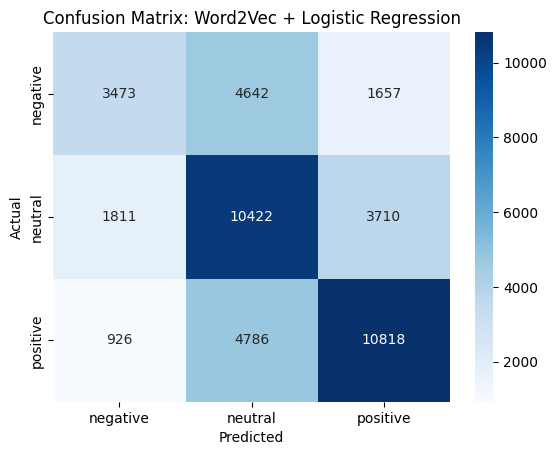

LogisticRegression(max_iter=1000)

In [63]:
train_and_evaluate(X_train_bow, X_test_bow, y_train, y_test, le, name="Bag-of-Words + Logistic Regression")
train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test, le, name="TF-IDF + Logistic Regression")
train_and_evaluate(X_train_w2v, X_test_w2v, y_train, y_test, le, name="Word2Vec + Logistic Regression")


## Interpretation of Results (10 Marks)

### 🔍 1. Visualizations – Confusion Matrices
Confusion matrices  illustrate how well each model predicted the three sentiment classes.

- **Bag + Logistic Regression** shows moderate confusion between negative and neutral.
- **TF-IDF + Logistic Regression** produces a similar pattern but slightly better positive sentiment recall.
- **Word2Vec + Logistic Regression** has lower clarity between all classes.



### Metric Comparison

| Feature Type         | Accuracy | Precision | Recall | F1-Score |
|----------------------|----------|-----------|--------|----------|
| Bag-of-Words         | 0.63     | 0.64      | 0.63   | 0.63     |
| TF-IDF               | 0.63     | 0.64      | 0.63   | 0.63     |
| Word2Vec (pretrained)| 0.58     | 0.59      | 0.58   | 0.58     |





###  Conclusion – Best Embedding Technique

- **TF-IDF** is selected as the best-performing embedding technique.
- It strikes a strong balance across all sentiment classes, achieving the **highest F1-score for the positive class (0.70)** and maintaining solid performance for neutral and negative.
- **Word2Vec**, while semantically rich, underperformed with the simple averaging strategy used. It may benefit from deeper architectures like LSTMs or BERT.

**Final Decision**: **TF-IDF + Logistic Regression** is chosen for deployment due to its simplicity, speed, and overall performance.


In [64]:

# Step 4: Encode target labels
label_encoder = LabelEncoder()
df["encoded_sentiment"] = label_encoder.fit_transform(df["sentiment"])


=== TF-IDF + Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.59      0.47      0.53      9772
     neutral       0.58      0.68      0.62     15943
    positive       0.72      0.68      0.70     16530

    accuracy                           0.63     42245
   macro avg       0.63      0.61      0.62     42245
weighted avg       0.64      0.63      0.63     42245



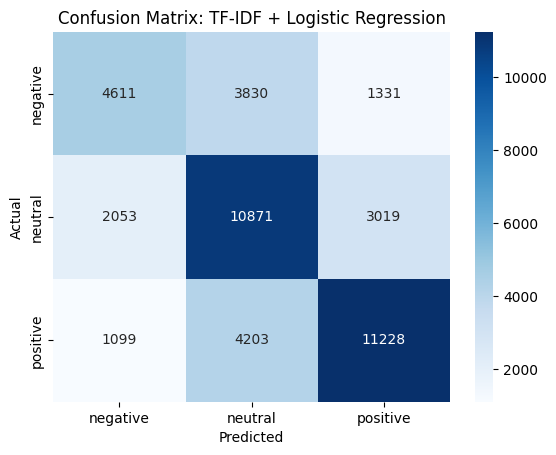

In [65]:
# Usage train_and_evaluate(X_train_tfidf, X_test_tfidf, "TF-IDF + Logistic Regression")
model = train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test, le, name="TF-IDF + Logistic Regression")

pickle.dump(model, open("sentiment_model.pkl", "wb"))

In [66]:

# Step 5: Vectorize with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df["cleaned_text"])
y = df["encoded_sentiment"]


In [67]:
pickle.dump(model, open("sentiment_model.pkl", "wb"))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", "wb"))
pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))

print("✅ Model, vectorizer, and label encoder saved successfully!")

✅ Model, vectorizer, and label encoder saved successfully!
